## LCM Model:

W ---> l <---- U ----> Y <---- Phi and l --> L

U is the latent process that generates both Ls and Ys here Ls are 0s and 1s and Y are gaussian processes

here also we introduce S trials for each Y. To accomodate these we fold up Y's in vectorized form
#### Now, $Y \in R^{S \times CN}, u \in R^{S \times PN }$ and ${ \bar{\phi} }$ is a block diagonal of size CN X PN with CXP matrix ${\phi}$ on diagonals. Also $W \in R^{1 \times PN}$ 

###  $Y= u * \bar{\phi}^T + \sigma^2I$
###  $l= b + u * W^T + s^2I$
####  L = -1 if l < $\mu$ L = +1 otherwise 

here b is the bias and s denotes the noise in label generation process


##### Also, $u \in GP(0,\bar{K})$ where $\bar{K}$ is also a blaock diagonal of size PN x PN with covariance kernels ${K_p \in R ^{N \times N}}$ for each  gaussian process on diagonals.

## This time we test the classification between two linear processes, i.e upward v/s downward slope

#### Load training Data
    -Training data consists of 40% upward linear and 60% downward linear time series with C =1
    - We have split the data into training and test sets already

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import LCMGP

In [1]:
import pickle
f = open("Y_train.pickle","rb")
YBar = (pickle.load(f))
f.close()
f = open("L_train.pickle","rb")
L = (pickle.load(f))
f.close()
f = open("Y_test.pickle","rb")
Y_test = (pickle.load(f))
f.close()
f = open("L_test.pickle","rb")
L_test = (pickle.load(f))
f.close()

(240, 60)

In [3]:
YBar = YBar*10
Y_test = Y_test*10

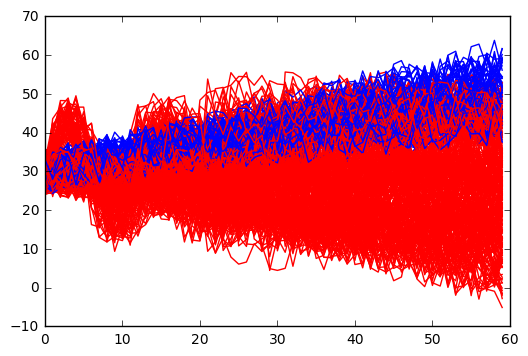

In [5]:
def plotLabel(YBar,L,S):
    for s in range(S):
        if L[s] < 0:
            plt.plot(YBar[s],c='r')
        else:
            plt.plot(YBar[s],c='b')
plotLabel(YBar,L,YBar.shape[0])

### Inference: 

#### Initializations:

### Variational Updates are:

#### For ${\hat{u}}$:

$q(\hat{u}) \propto N(\hat{u}|(y<\phi> + <w><l>\sigma^2 - <w><b>\sigma^2){K}_{pNpn}K_{pn}^{-1}\Sigma_{u}^{-1}, \hat{\Sigma}_{u}^{-1})$
where $ \hat{\Sigma}_{u} = K_{pn}^{-1} + \frac{1}{\sigma^2}K_{pn}^{-1}K_{pnpN}F_uK_{pNpn}K_{pn}^{-1}$
and $F_u = <{\phi}^T{\phi}>_{\phi} + \sigma^2<w^Tw>_w = Var(\phi) + <\phi>^T<\phi> + Var(w) + <w>^T<w>$ , 

#### For ${u}$:

${q(u) \propto N (\hat{\mu}M, \Sigma_{u|u^{p}} + M\Sigma_{u}M^{T})}$


where $\hat{\mu}_{u}$ is the mean and ${\hat{\Sigma}_{u}}$ variance of $\hat{u}$

Also  $\Sigma_{u|u^{p}} = K_{pNpN} - K_{pNpn}K_{pn}^{-1}K_{pnpN}$ , $M = K_{pn}^{-1}K_{pNpn}$

#### For $\phi$:

$\phi = N(\phi| (\bar{V}_{\phi} + I)^{-1}\bar{z}_{\phi}, (\bar{V}_{\phi} + I)^{-1})$
where $\bar{V}_{\phi} = \sum_{s}^{S}(<\bar{u}_s><\bar{u}_s>^T$ + I)
and $\bar{z}_{\phi} = \sum_{s}^{S}<\bar{u}_s>\bar{y}_{s}^T$
here $x = vec(\bar{x})$ 

#### For l:

$q(l_i) \propto TN(l_i| (<w><u> + <b>, 2*I, l_i < \mu)$
where TN is truncated normal distribution

#### For W:

$W \propto N(w | [F_u+I]^{-1}(<U>^T<l>^T - <U>^T<b>^T,[F_u+I]^{-1})$
where $F_u = <{U}^T{U}>_{U}$

#### For B:

$b \propto N(b | (<l>^T - <U><w>^T,I)$


### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(F_{p}^{-1}y<\phi> | <U>, F_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$


In [6]:
lcgm = LCMGP.LCMGP()

In [7]:
lcgm.fit(Y=YBar,L=L,N=60,induction=0.5,iterations=50)

Model initialized with  0.5 induction ratio
50 updates


## Inferred PhiHat

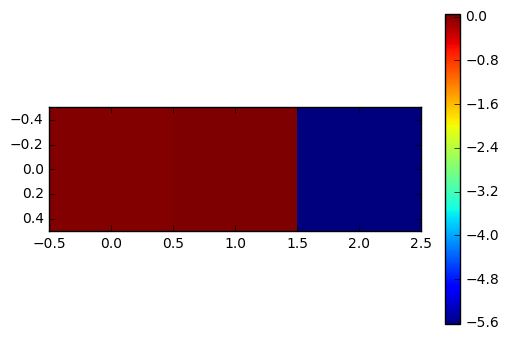

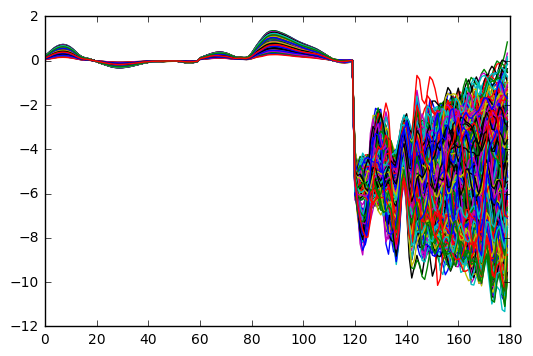

In [8]:
plt.imshow(lcgm.phiHatExp,interpolation='none')
plt.colorbar()
plt.show()
i=plt.plot(lcgm.uExpBar.T)
plt.show()

## Training Data in latent Space

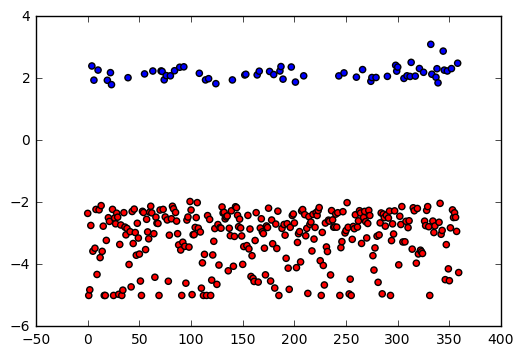

In [9]:
def getColor(l):
    if t < 0:
        return 'r'
    else:
        return 'b'
    
plt.scatter(range(lcgm.lHatExp.shape[0]),lcgm.lHatExp,c=[getColor(t) for t in L])


- We see that it's well separated. Too good even

(array([ 10.,  11.,  20.,  28.,  47.,  27.,  20.,   4.,   5.,   8.]),
 array([-0.25520906, -0.17270525, -0.09020144, -0.00769764,  0.07480617,
         0.15730998,  0.23981378,  0.32231759,  0.40482139,  0.4873252 ,
         0.56982901]),
 <a list of 10 Patch objects>)

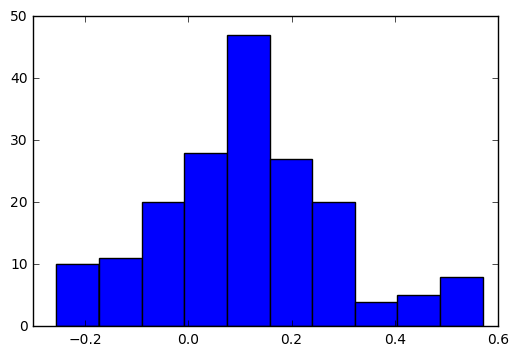

In [28]:
plt.hist(lcgm.WHatExp.T)

In [12]:
import numpy as np
totalError = 0
for s in range(YBar.shape[0]):
    totalError += np.sum(np.abs(YBar[s] - lcgm.uExpBar[s]*lcgm.phiHatExpBar.T))
print totalError/YBar.shape[0]

151.979129657


## Now checking performance on test data

In [36]:
lpred,ltest,utest = lcgm.predict(Y_test)

## Checking separation in latent space

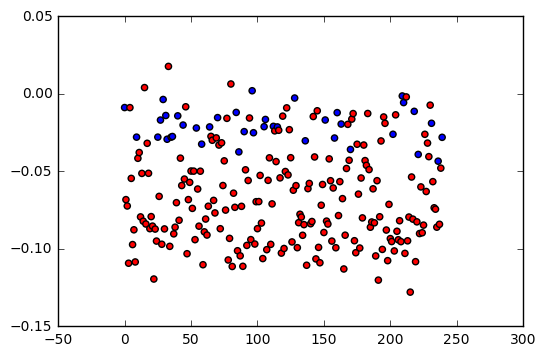

In [37]:
plt.scatter(range(ltest.shape[0]),ltest,c=[getColor(t) for t in L_test])

#### Here we see that even test data is well separated. A histogram of latent values from test data will also confirms this: 

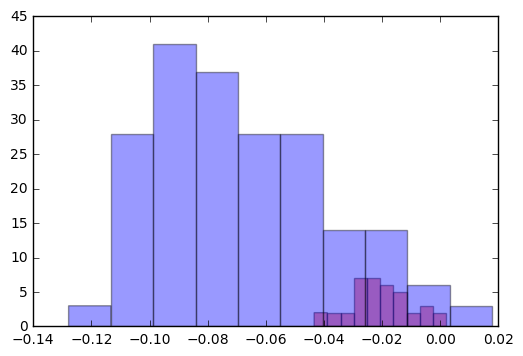

In [38]:
plt.hist(ltest[L_test==1],color='r',alpha=0.4)
plt.hist(ltest[L_test==-1],color='b',alpha=0.4)
plt.show()

### However, interestingly , if I calcualte latent values through truncated normal distribution I get very weird results.

In [49]:
from scipy.interpolate import interp1d
def scaleBack(x):
    m = interp1d([np.min(x),np.max(x)],[-1,1])
    return m(x)

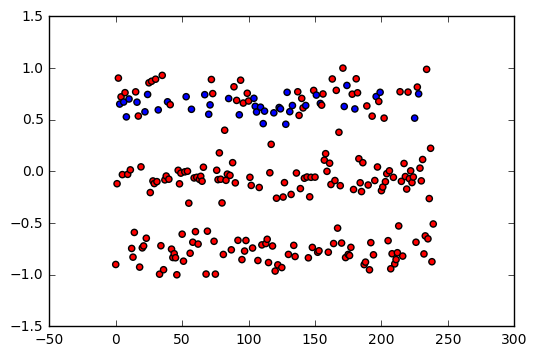

In [51]:
scaledLtest = scaleBack(ltest)
plt.scatter(range(scaledLtest.shape[0]),scaledLtest,c=[getColor(t) for t in L_test])

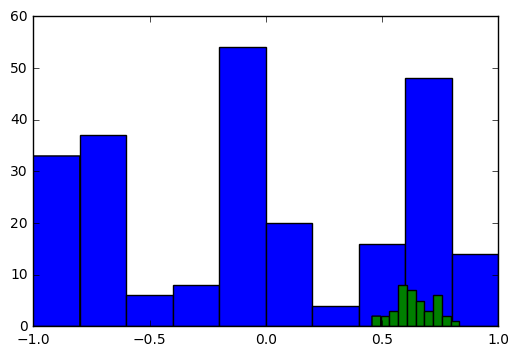

In [78]:
plt.hist(scaledLtest)
plt.hist(scaledLtest[L_test > 0])
plt.show()

### Three clusters of values seen here correspond to downward slope-shift, cyclic-normal and upward slope-shift respectively

    - Model automatically finds these clusters even though we only wanted to separate upward slope classes
    - It combines upward slope with upward shift since the lenght scale of gaussian process kernel is high, so from a covariance point of view upward slope and upward shift both look the same

In [72]:
jumbled = Ytest[(scaledLtest < -0.5)]

In [73]:
print jumbled.shape, Ytest.shape

(76, 60) (240, 60)


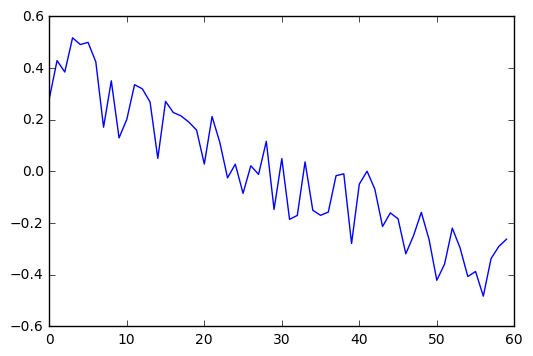

In [74]:
i=plt.plot(jumbled[2])